In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [42]:
%pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

Note: you may need to restart the kernel to use updated packages.


In [5]:
import tensorflow as tf
import transformers
from transformers import BertTokenizer, TFBertModel

In [8]:
# Detect GPU, return appropriate distribution strategy

# Check if a GPU is available
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Set GPU memory growth to minimize memory allocation issues
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    # Create a MirroredStrategy for multi-GPU setups (if available)
    if len(gpus) > 1:
        strategy = tf.distribute.MirroredStrategy()
        print("Running on multiple GPUs")
    else:
        strategy = tf.distribute.OneDeviceStrategy(device="/GPU:0")
        print("Running on a single GPU")
else:
    # No GPU found, use the default strategy (CPU)
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print("REPLICAS available: ", strategy.num_replicas_in_sync)

Running on CPU
REPLICAS available:  1


## EDA

In [37]:
data = pd.concat([
  pd.read_csv("Train.csv"), 
  pd.read_csv("valid.csv")
])

data.head()

Id                                              Title  \
0  34552656             Java: Repeat Task Every Random Seconds   
1  34553034                  Why are Java Optionals immutable?   
2  34553174  Text Overlay Image with Darkened Opacity React...   
3  34553318         Why ternary operator in swift is so picky?   
4  34553755                 hide/show fab with scale animation   

                                                Body  \
0  <p>I'm already familiar with repeating tasks e...   
1  <p>I'd like to understand why Java 8 Optionals...   
2  <p>I am attempting to overlay a title over an ...   
3  <p>The question is very simple, but I just cou...   
4  <p>I'm using custom floatingactionmenu. I need...   

                                                Tags         CreationDate  \
0                                     <java><repeat>  2016-01-01 00:21:59   
1                                   <java><optional>  2016-01-01 02:03:20   
2  <javascript><image><overlay><react-native><opa...  2016-01-01 02:48:24   
3  <swift><operators><whitespace><ternary-operato...  2016-01-01 03:30:17   
4  <android><material-design><floating-action-but...  2016-01-01 05:21:48   

          Y  
0  LQ_CLOSE  
1        HQ  
2        HQ  
3        HQ  
4        HQ

In [38]:
data['Tags'] = data['Tags'].str.replace('>',',')
data['Tags'] = data['Tags'].str.replace('<','')

data['Tags'].head()

0                                         java,repeat,
1                                       java,optional,
2       javascript,image,overlay,react-native,opacity,
3    swift,operators,whitespace,ternary-operator,op...
4      android,material-design,floating-action-button,
Name: Tags, dtype: object

In [39]:
data['Y'].value_counts()

Y
LQ_CLOSE    20000
HQ          20000
LQ_EDIT     20000
Name: count, dtype: int64

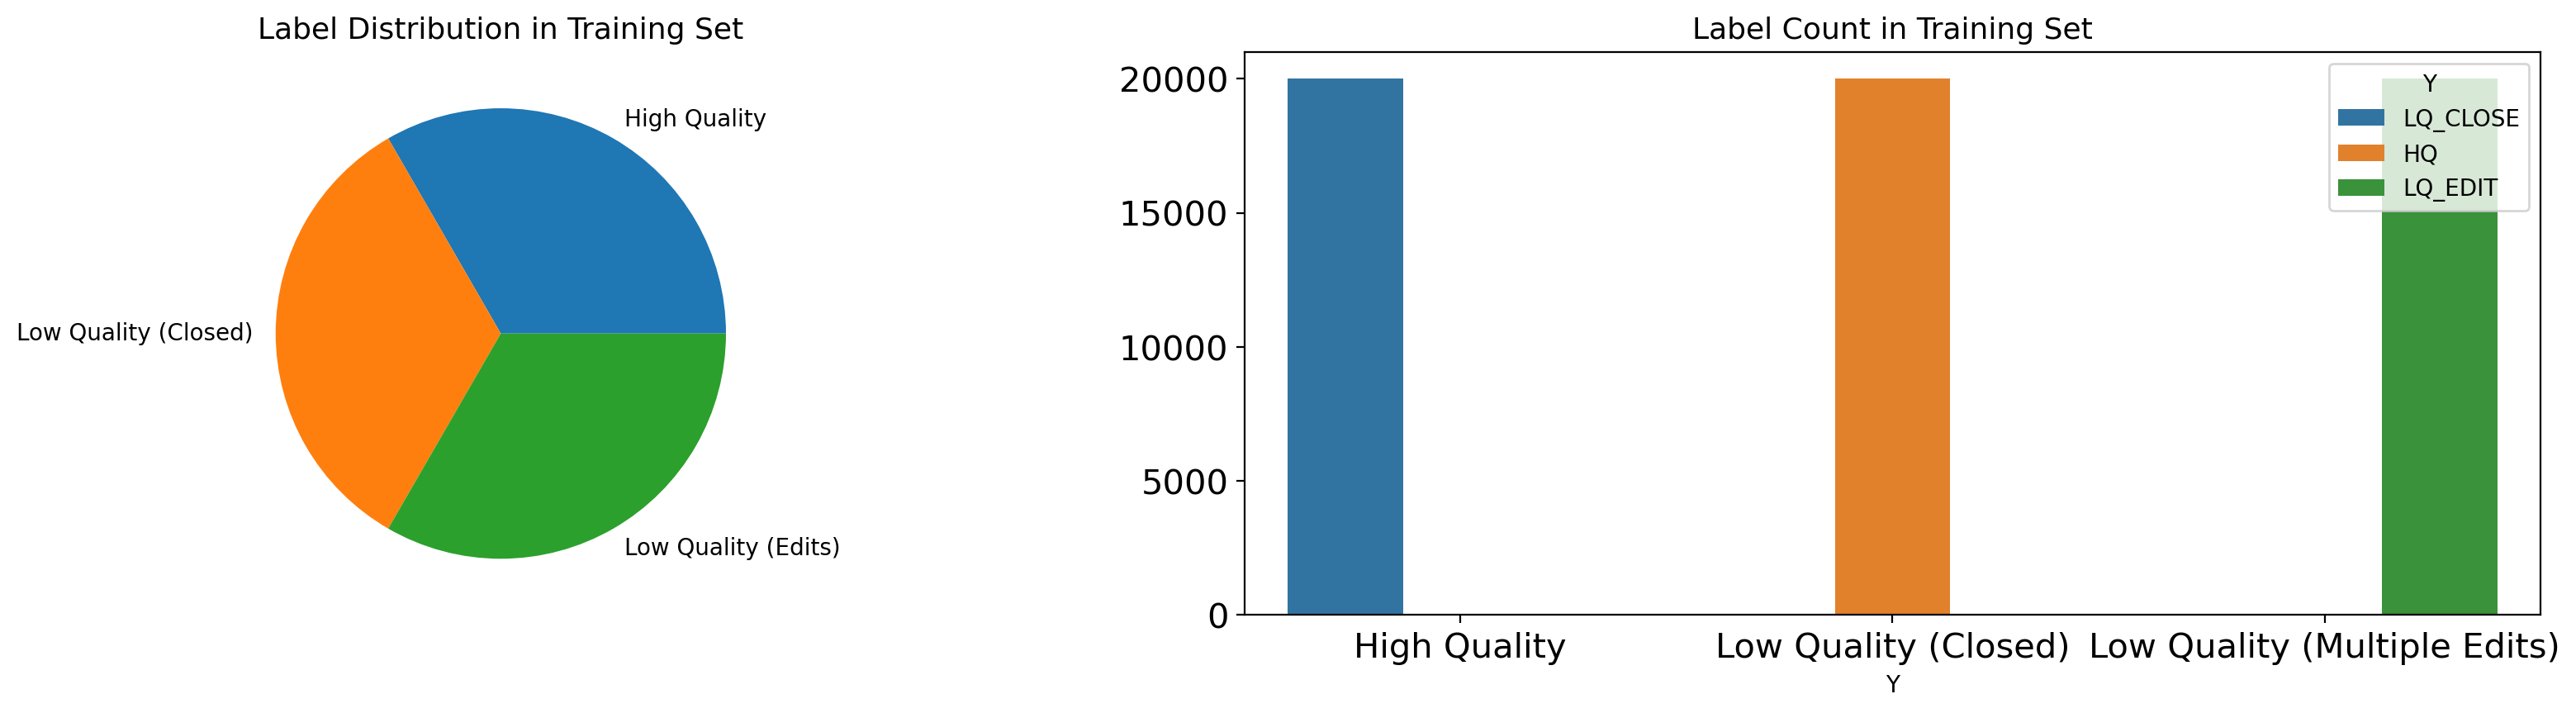

In [ ]:
fig, axes = plt.subplots(ncols = 2, figsize = (18, 4), dpi = 200)
plt.tight_layout()

data.groupby('Y').count()['Id'].plot(kind = 'pie', ax = axes[0], labels = ['High Quality', 'Low Quality (Closed)', 'Low Quality (Edits)'])
sns.countplot(x = data['Y'], hue = data['Y'], ax = axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['High Quality', 'Low Quality (Closed)', 'Low Quality (Multiple Edits)'])
axes[0].tick_params(axis = 'x', labelsize = 15)
axes[0].tick_params(axis = 'y', labelsize = 15)
axes[1].tick_params(axis = 'x', labelsize = 15)
axes[1].tick_params(axis = 'y', labelsize = 15)

axes[0].set_title('Label Distribution in Training Set', fontsize = 13)
axes[1].set_title('Label Count in Training Set', fontsize = 13)

plt.show()

### Combine Body and Title into one Column

### Remove <> from question

In [41]:
data['Text'] = data['Title'] + " " + data['Body']
data['Text'] = data['Text'].str.replace('>',',')
data['Text'] = data['Text'].str.replace('<','')
# df = df.drop(columns=['Title', 'Body'])
data.head()

Id                                              Title  \
0  34552656             Java: Repeat Task Every Random Seconds   
1  34553034                  Why are Java Optionals immutable?   
2  34553174  Text Overlay Image with Darkened Opacity React...   
3  34553318         Why ternary operator in swift is so picky?   
4  34553755                 hide/show fab with scale animation   

                                                Body  \
0  <p>I'm already familiar with repeating tasks e...   
1  <p>I'd like to understand why Java 8 Optionals...   
2  <p>I am attempting to overlay a title over an ...   
3  <p>The question is very simple, but I just cou...   
4  <p>I'm using custom floatingactionmenu. I need...   

                                                Tags         CreationDate  \
0                                       java,repeat,  2016-01-01 00:21:59   
1                                     java,optional,  2016-01-01 02:03:20   
2     javascript,image,overlay,react-native,opacity,  2016-01-01 02:48:24   
3  swift,operators,whitespace,ternary-operator,op...  2016-01-01 03:30:17   
4    android,material-design,floating-action-button,  2016-01-01 05:21:48   

          Y                                               Text  
0  LQ_CLOSE  Java: Repeat Task Every Random Seconds p,I'm a...  
1        HQ  Why are Java Optionals immutable? p,I'd like t...  
2        HQ  Text Overlay Image with Darkened Opacity React...  
3        HQ  Why ternary operator in swift is so picky? p,T...  
4        HQ  hide/show fab with scale animation p,I'm using...

### WORDCLOUD

In [43]:
comment_words = ''
stopwords = set(STOPWORDS)

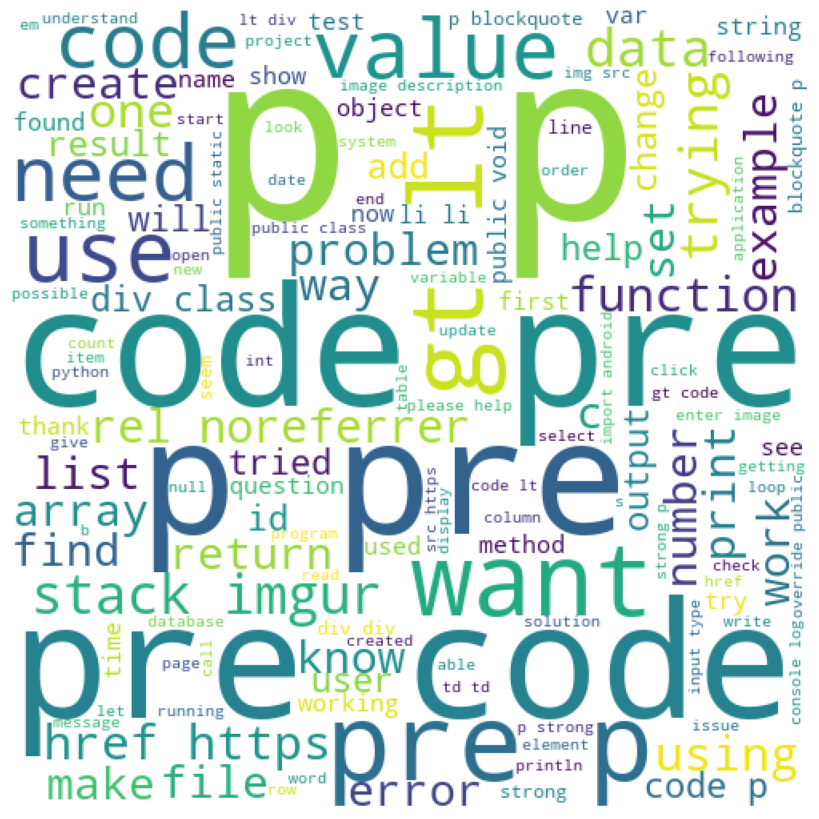

In [49]:
HQ_Question = data[data['Y'] == 'HQ']

for val in HQ_Question['Text']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 500, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

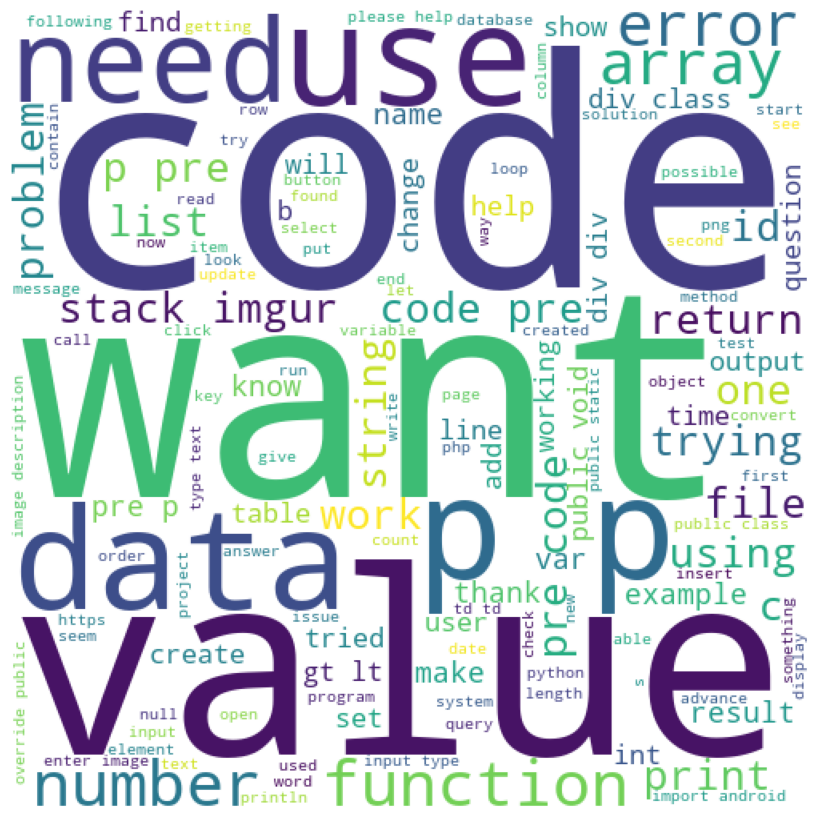

In [48]:
LQ_Edit = data[data['Y'] == 'LQ_EDIT']

for val in LQ_Edit['Text']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 500, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                  
plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

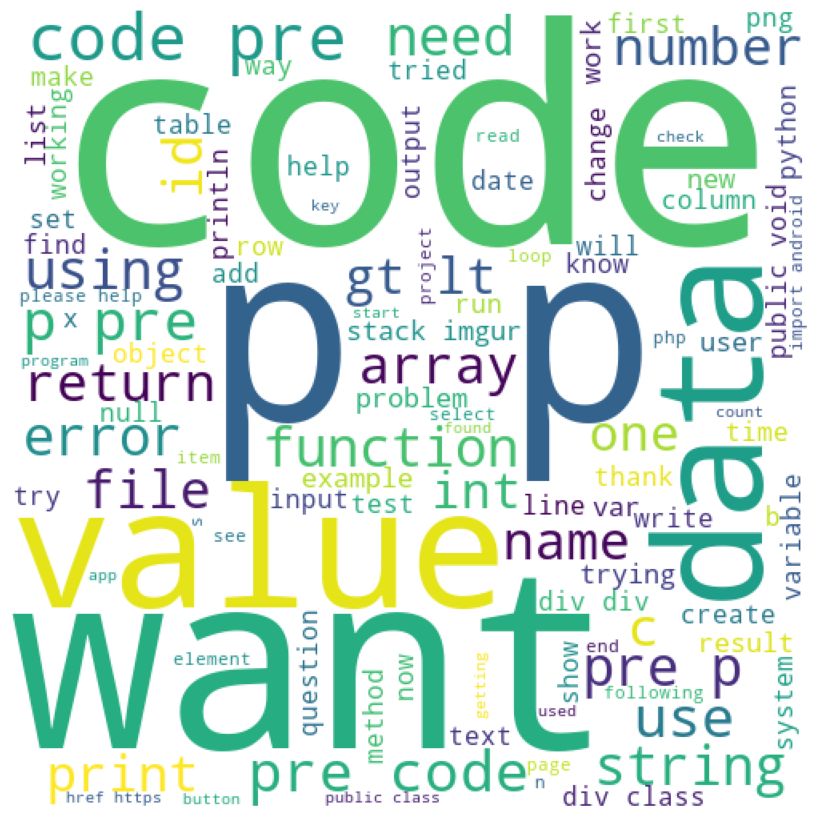

In [47]:
LQ_Close = data[data['Y'] == 'LQ_CLOSED']

for val in LQ_Close['Text']:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 500, height = 500,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                   
plt.figure(figsize = (8, 8))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

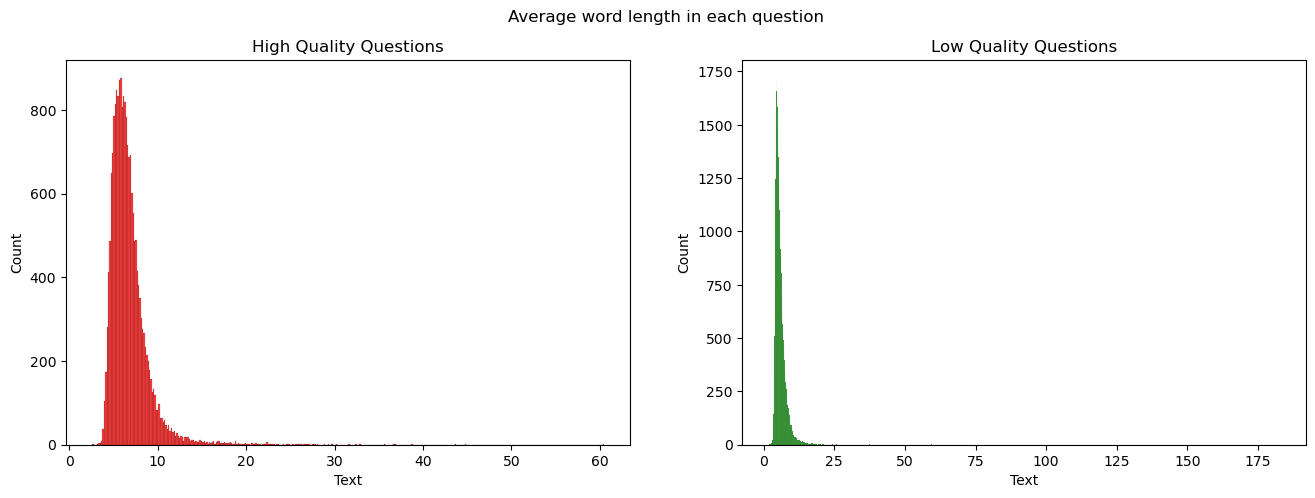

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# High-Quality Questions
word = data[data['Y'] == 'HQ']['Text'].str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)), ax=ax1, color='red')
ax1.set_title('High Quality Questions')

# Low-Quality Questions
word = data[(data['Y'] == 'LQ_EDIT') | (data['Y'] == 'LQ_CLOSE')]['Text'].str.split().apply(lambda x: [len(i) for i in x])
sns.histplot(word.map(lambda x: np.mean(x)), ax=ax2, color='green')
ax2.set_title('Low Quality Questions')

fig.suptitle('Average word length in each question')
plt.show()

## Preprocessing

## Split the Dataset

In [55]:
%pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/59/ed/548f6f686845d386a727a51a3daa411d95fc599649a2d54705f6773ac259/scikit_learn-1.3.1-cp310-cp310-win_amd64.whl.metadata
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
    --------------------------------------- 0.1/9.3 MB 3.6 MB/s eta 0:00:03
   - -------------------------------------- 0.3/9.3 MB 5.0 MB/s eta 0:00:02
   -- ------------------------------------- 0.6/9.3 MB 5.3 MB/s eta 0:00:02
   --- ------------------------------------ 0.9/9.3 MB 5.6 MB/s

In [70]:
targets = {'HQ': 0, 'LQ_EDIT': 1, 'LQ_CLOSE': 2}
data['Y'] = data['Y'].map(targets)

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data["Text"], data["Y"], test_size=0.3, random_state=42, stratify=data["Y"])

In [72]:
y_train.value_counts()

Y
2    14000
0    14000
1    14000
Name: count, dtype: int64

In [73]:
y_test.value_counts()

Y
1    6000
0    6000
2    6000
Name: count, dtype: int64

In [67]:
%pip install -U "tensorflow-text==2.13.*"
%pip install "tf-models-official==2.13.*"

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow-text==2.13.* (from versions: 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0, 2.10.0b2, 2.10.0rc0, 2.10.0)
ERROR: No matching distribution found for tensorflow-text==2.13.*


  Obtaining dependency information for tf-models-official==2.13.* from https://files.pythonhosted.org/packages/d8/c3/4511e49412492966f4e6e0a20b41ae66d027e5a76e8c2b436b591ecc4273/tf_models_official-2.13.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for Cython from https://files.pythonhosted.org/packages/db/3e/8cf60af86446b129e79adee5d9131ec7eb043297e20c04bc31670331325c/Cython-3.0.2-cp310-cp310-win_amd64.whl.metadata
     ---------------------------------------- 0.0/61.3 kB ? eta -:--:--
     --------------------------------- ------ 51.2/61.3 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 61.3/61.3 kB 1.6 MB/s eta 0:00:00
  Obtaining dependency information for google-api-python-client>=1.6.7 from https://files.pythonhosted.org/packages/f8/e9/11fb73fe17f63e2e8aa7c1f4afb790ab737c0881dce4757bdead998ef48d/google_api_python_client-2.102.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for immutabledict from https://files.pythonhost

  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [62 lines of output]
      C:\Users\Keita\AppData\Local\Temp\pip-build-env-rdp63d5p\overlay\Lib\site-packages\setuptools\config\setupcfg.py:293: _DeprecatedConfig: Deprecated config in `setup.cfg`
      !!
      
              ********************************************************************************
              The license_file parameter is deprecated, use license_files instead.
      
              By 2023-Oct-30, you need to update your project and remove deprecated calls
              or your builds will no longer be supported.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              ********************************************************************************
      
      !!
        parsed = self.parsers.get(option_name, lambda x: x)(value)
      running egg_info
      writing 

In [68]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
model = TFBertModel.from_pretrained("bert-large-uncased")

c:\Users\Keita\anaconda3\envs\tensorflow\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Keita\anaconda3\envs\tensorflow\lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Keita\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see t

In [74]:
def regular_encode(texts, tokenizer, maxlen = 512):
    enc_di = tokenizer.batch_encode_plus(texts, return_attention_masks = False, return_token_type_ids = False, pad_to_max_length = True, max_length = maxlen)
    return np.array(enc_di['input_ids'])

In [77]:
Xtrain_encoded = regular_encode(X_train.astype('str'), tokenizer, maxlen = 128)
ytrain_encoded = tf.keras.utils.to_categorical(y_train, num_classes = 3, dtype = 'int32')
Xtest_encoded = regular_encode(X_test.astype('str'), tokenizer, maxlen = 128)
ytest_encoded = tf.keras.utils.to_categorical(y_test, num_classes = 3, dtype = 'int32')

c:\Users\Keita\anaconda3\envs\tensorflow\lib\site-packages\transformers\tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': False} not recognized.
Keyword arguments {'return_attention_masks': 

In [78]:
def build_model(transformer, loss = 'categorical_crossentropy', max_len = 512):
    input_word_ids = tf.keras.layers.Input(shape = (max_len,), dtype = tf.int32, name = "input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]

    #adding dropout layer
    x = tf.keras.layers.Dropout(0.40)(cls_token)

    #using a dense layer of 3 neurons as the number of unique categories is 3. 
    out = tf.keras.layers.Dense(3, activation = 'sigmoid')(x)

    model = tf.keras.Model(inputs = input_word_ids, outputs = out)
    model.compile(tf.keras.optimizers.Adam(lr = 3e-5), loss = loss, metrics = ['accuracy'])
    return model

In [81]:
with strategy.scope():
    transformer_layer = transformers.TFAutoModel.from_pretrained('bert-large-uncased')
    model = build_model(transformer_layer, max_len = 128)
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 128)]            0         
                                                                 
 tf_bert_model_1 (TFBertMode  TFBaseModelOutputWithPoo  335141888
 l)                          lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             128, 1024),                         
                              pooler_output=(None, 10            
                             24),                                
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

c:\Users\Keita\anaconda3\envs\tensorflow\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [82]:
BATCH_SIZE = 32*strategy.num_replicas_in_sync
AUTO = tf.data.experimental.AUTOTUNE 
train_dataset = (tf.data.Dataset.from_tensor_slices((Xtrain_encoded, ytrain_encoded)).repeat().shuffle(2048).batch(BATCH_SIZE).prefetch(AUTO))
test_dataset = (tf.data.Dataset.from_tensor_slices(Xtest_encoded).batch(BATCH_SIZE))

In [83]:
n_steps = Xtrain_encoded.shape[0] // BATCH_SIZE
train_history = model.fit(train_dataset, steps_per_epoch = n_steps, epochs = 20)

Epoch 1/20
